In [1]:
%matplotlib inline

In [2]:

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generator/")
from environments import Environments

import umap
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("project_style.mplstyle")

import stats
import analysis_tools

In [3]:
def plot_3d_proj(data, tags = None, cmap = "viridis", title = "", axes = None):
    if axes is None:
        fig = plt.figure(figsize = (6,6))
        ax = fig.add_subplot(projection='3d')
    else:
        ax = axes
    ax.set_title(title)
    #norm = matplotlib.colors.Normalize(np.amin(tags), np.amax(tags))
    #col = matplotlib.cm.tab20c(norm(tags))
    ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2], c = tags, s =5, alpha = 0.5, cmap = cmap, edgecolors=None)
    ax.axis("off")
    
    if axes is None:
        return fig    

In [4]:
def fit_umap(data, components = 2):
    fit = umap.UMAP(n_components = components)
    transformed = fit.fit_transform(data)
    return transformed

In [5]:
model_name = f"../models/al1_10_l2_0"
path = f"../models/{model_name}"
model, params = analysis_tools.load_model(path, device = "cpu", model_type = "RNN")

In [6]:
env = Environments()
sequence = list(env.envs)
n_envs = len(sequence)
limits = 1.1*np.array([-1.5, 1.5, -1.5, 1.5])

timesteps = 10000

In [7]:
recurrent_weights = model.g.weight_hh_l0.detach().cpu().numpy()

# for i in range(len(recurrent_weights)):
#         recurrent_weights[i, i] = np.nan

In [8]:
eps = 1e-3
nonzero = np.sum(np.abs(recurrent_weights), axis = -1) > eps

In [9]:
context_weights = model.g.weight_ih_l0.detach().cpu().numpy()[:,2:] # first two are velocity inputs

In [10]:
recurrent_eigenvalues = np.linalg.eigvals(recurrent_weights)
recurrent_eigenvalues = recurrent_eigenvalues[np.real(recurrent_eigenvalues) == recurrent_eigenvalues]
recurrent_eigenvalues = np.real(recurrent_eigenvalues)

(-5.0, 60.900000000000006, 0.0, 1.2670144379138948)

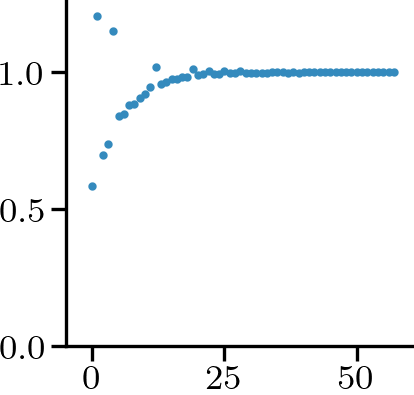

In [11]:
plt.plot(recurrent_eigenvalues, "o")
plt.axis([-5, len(recurrent_eigenvalues)*1.05, 0, np.amax(recurrent_eigenvalues)*1.05])

In [12]:
gramian = np.zeros((n_envs, n_envs))

for i in range(n_envs):
    for j in range(n_envs):
        gramian[i,j] = np.corrcoef(context_weights[:,i], context_weights[:,j])[0,1]

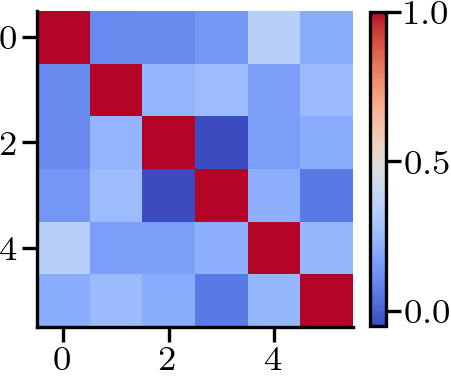

In [13]:
plt.imshow(gramian, cmap = "coolwarm")
plt.colorbar(pad = 0.05, fraction  =0.045)

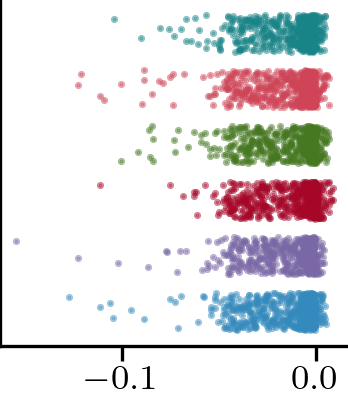

In [22]:
for i in range(n_envs):
    plt.scatter(context_weights[:,i], i*context_weights.shape[0]*1.5 + np.arange(context_weights.shape[0]), s = 0.5, alpha = 0.5)
    plt.yticks([])

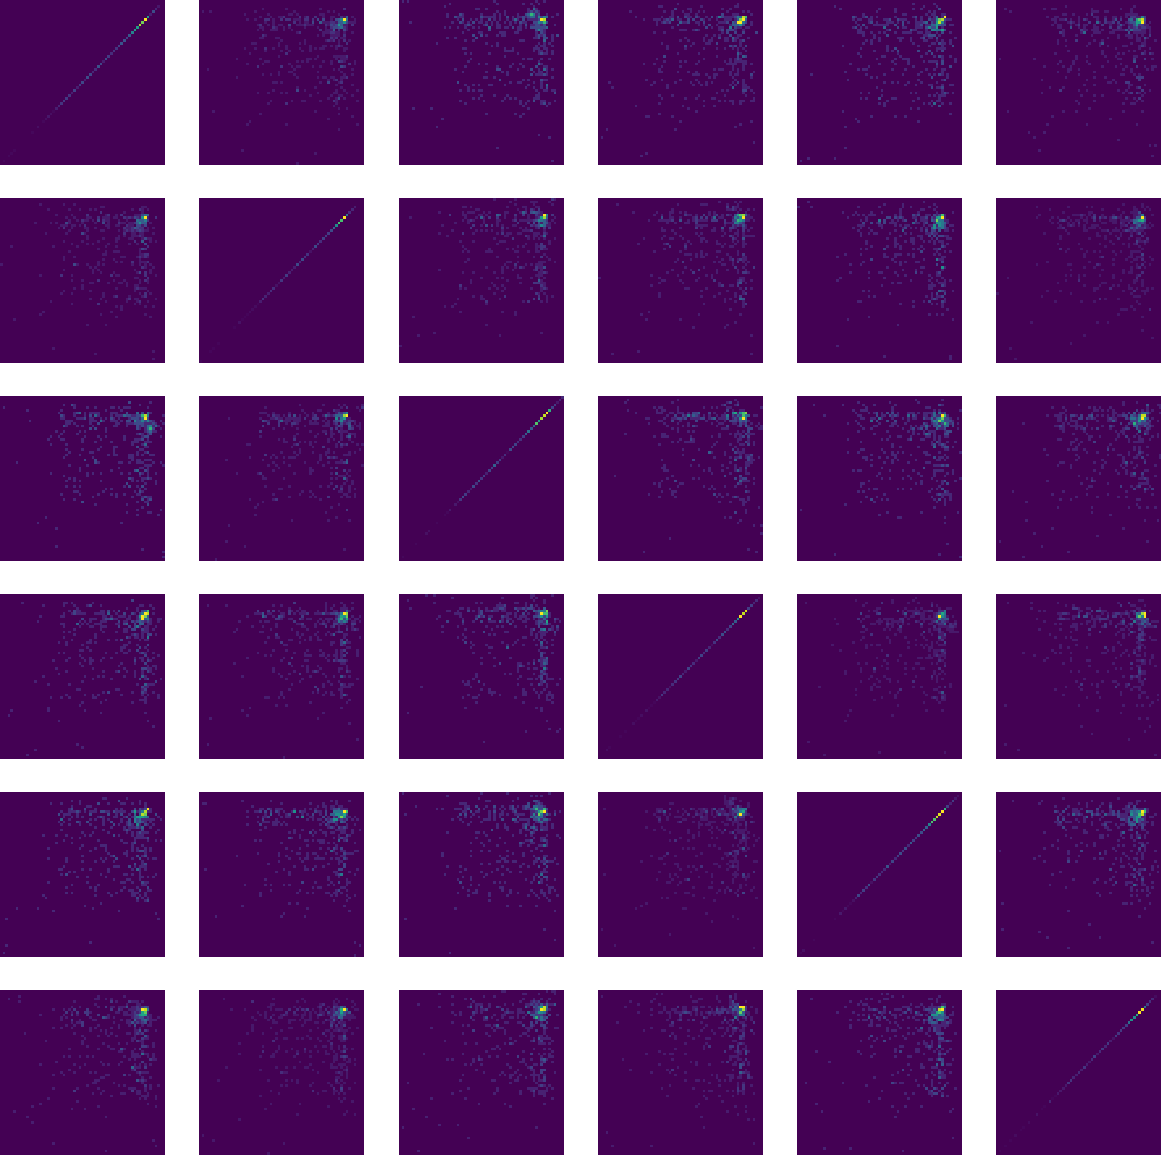

In [15]:
fig, ax = plt.subplots(n_envs, n_envs, figsize = (5, 5))

bins = np.linspace(np.amin(context_weights)*0.5, np.amax(context_weights), 64)

for i in range(n_envs):
    for j in range(n_envs):
        hist = np.histogram2d(context_weights[:,i], context_weights[:,j], bins = bins)[0]
        ax[i,j].imshow(hist.T, origin = "lower")
        ax[i,j].axis("off")

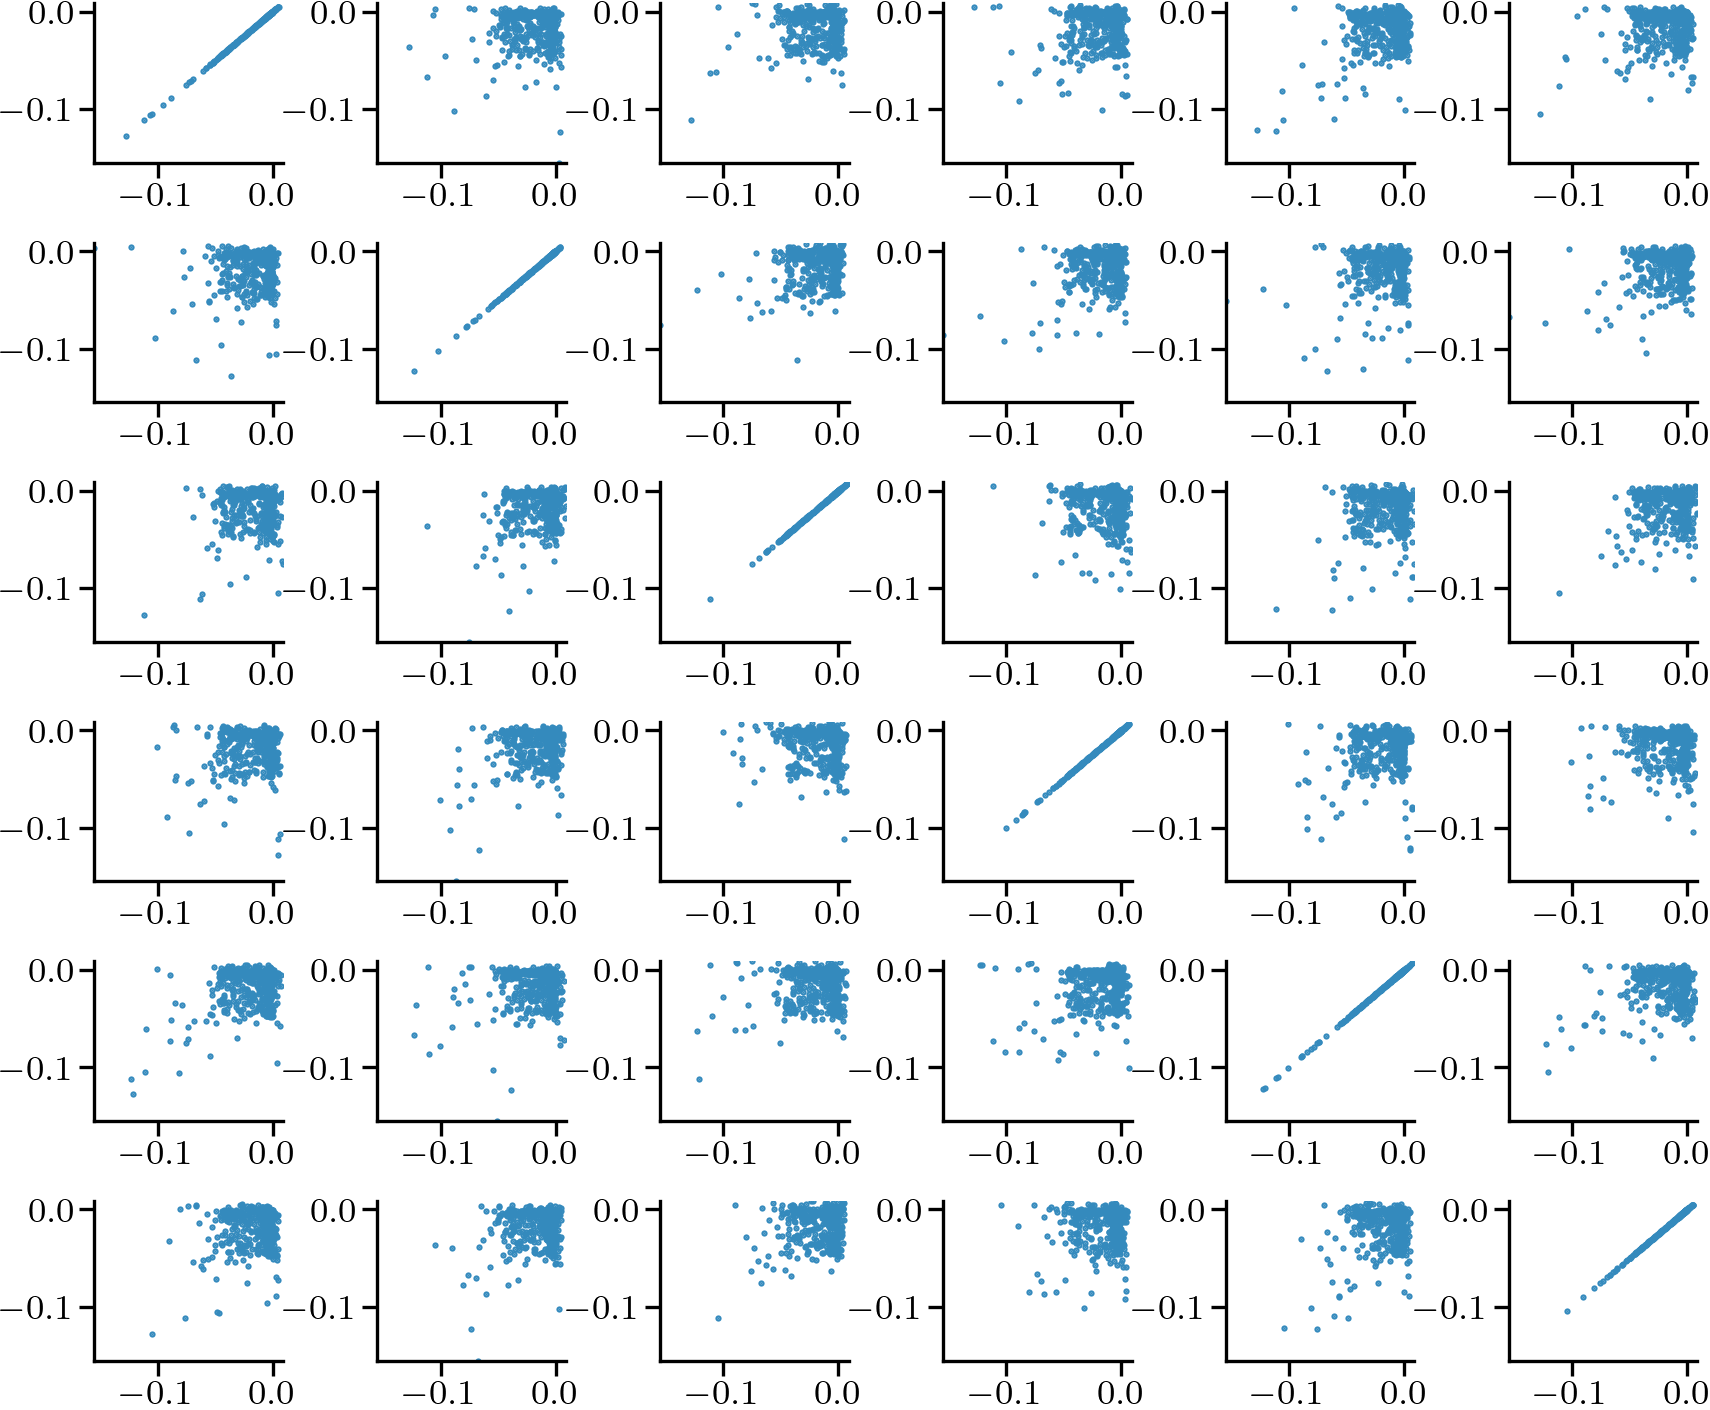

In [21]:
fig, ax = plt.subplots(n_envs, n_envs, figsize = (6, 5))

lims = [np.amin(context_weights), np.amax(context_weights), np.amin(context_weights), np.amax(context_weights)]

for i in range(n_envs):
    for j in range(n_envs):
        ax[i,j].plot(context_weights[:,i], context_weights[:,j], ".")
        ax[i,j].axis(lims)
plt.tight_layout()

plt.subplots_adjust(wspace=0.45, hspace= 0.45)